<img src="http://dask.readthedocs.io/en/latest/_images/dask_horizontal.svg"
     align="right"
     width="30%"
     alt="Dask logo\">


# Dask DataFrames

We finished Chapter 1 by building a parallel dataframe computation over a directory of CSV files using `dask.delayed`.  In this section we use `dask.dataframe` to automatically build similar computations, for the common case of tabular computations.  Dask dataframes look and feel like Pandas dataframes but they run on the same infrastructure that powers `dask.delayed`.

In this notebook we use the same airline data as before, but now rather than write for-loops we let `dask.dataframe` construct our computations for us.  The `dask.dataframe.read_csv` function can take a globstring like `"data/nycflights/*.csv"` and build parallel computations on all of our data at once.

## When to use `dask.dataframe`

Pandas is great for tabular datasets that fit in memory. Dask becomes useful when the dataset you want to analyze is larger than your machine's RAM. The demo dataset we're working with is only about 200MB, so that you can download it in a reasonable time, but `dask.dataframe` will scale to  datasets much larger than memory.

<img src="images/pandas_logo.png" align="right" width="28%">

The `dask.dataframe` module implements a blocked parallel `DataFrame` object that mimics a large subset of the Pandas `DataFrame` API. One Dask `DataFrame` is comprised of many in-memory pandas `DataFrames` separated along the index. One operation on a Dask `DataFrame` triggers many pandas operations on the constituent pandas `DataFrame`s in a way that is mindful of potential parallelism and memory constraints.

**Related Documentation**

* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

**Main Take-aways**

1.  Dask DataFrame should be familiar to Pandas users
2.  The partitioning of dataframes is important for efficient execution

## Create data

In [1]:
%run prep.py -d accounts
%run prep.py -d flights

## Setup

In [2]:
from dask.distributed import Client

client = Client(n_workers=4)

We load the accounts data.

In [3]:
import os
import dask
filename = os.path.join('data', 'accounts.*.csv')
filename

'data/accounts.*.csv'

Filename includes a glob pattern `*`, so all files in the path matching that pattern will be read into the same Dask DataFrame.

In [4]:
import dask.dataframe as dd
df = dd.read_csv(filename)
df.head()

/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)


,id,names,amount
0,55,Yvonne,2309
1,4,Michael,1469
2,32,Zelda,935
3,35,Zelda,338
4,29,Kevin,58


In [5]:
# load and count number of rows
len(df)

30000

What happened here?
- Dask investigated the input path and found that there are three matching files 
- a set of jobs was intelligently created for each chunk - one per original CSV file in this case
- each file was loaded into a pandas dataframe, had `len()` applied to it
- the subtotals were combined to give you the final grand total.

### Real Data

Lets try this with an extract of flights in the USA across several years. This data is specific to flights out of the three airports in the New York City area.

In [6]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]})

Notice that the respresentation of the dataframe object contains no data - Dask has just done enough to read the start of the first file, and infer the column names and dtypes.

In [7]:
df

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
npartitions=10,,,,,,,,,,,,,,,,,,,,,
,datetime64[ns],int64,float64,int64,float64,int64,object,int64,float64,float64,int64,float64,float64,float64,object,object,float64,float64,float64,int64,int64
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...


We can view the start and end of the data

In [8]:
df.head()

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990-01-01,1,1621.0,1540,1747.0,1701,US,33,NaN,86.0,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990-01-02,2,1547.0,1540,1700.0,1701,US,33,NaN,73.0,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990-01-03,3,1546.0,1540,1710.0,1701,US,33,NaN,84.0,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990-01-04,4,1542.0,1540,1710.0,1701,US,33,NaN,88.0,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990-01-05,5,1549.0,1540,1706.0,1701,US,33,NaN,77.0,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [9]:
df.tail()  # this fails

/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
distributed.w

ValueError: Mismatched dtypes found in `pd.read_csv`/`pd.read_table`.

+----------------+---------+----------+
| Column         | Found   | Expected |
+----------------+---------+----------+
| CRSElapsedTime | float64 | int64    |
| TailNum        | object  | float64  |
+----------------+---------+----------+

The following columns also raised exceptions on conversion:

- TailNum
  ValueError("could not convert string to float: 'N54711'")

Usually this is due to dask's dtype inference failing, and
*may* be fixed by specifying dtypes manually by adding:

dtype={'CRSElapsedTime': 'float64',
       'TailNum': 'object'}

to the call to `read_csv`/`read_table`.

### What just happened?

Unlike `pandas.read_csv` which reads in the entire file before inferring datatypes, `dask.dataframe.read_csv` only reads in a sample from the beginning of the file (or first file if using a glob). These inferred datatypes are then enforced when reading all partitions.

In this case, the datatypes inferred in the sample are incorrect. The first `n` rows have no value for `CRSElapsedTime` (which pandas infers as a `float`), and later on turn out to be strings (`object` dtype). Note that Dask gives an informative error message about the mismatch. When this happens you have a few options:

- Specify dtypes directly using the `dtype` keyword. This is the recommended solution, as it's the least error prone (better to be explicit than implicit) and also the most performant.
- Increase the size of the `sample` keyword (in bytes)
- Use `assume_missing` to make `dask` assume that columns inferred to be `int` (which don't allow missing values) are actually floats (which do allow missing values). In our particular case this doesn't apply.

In our case we'll use the first option and directly specify the `dtypes` of the offending columns. 

In [10]:
df = dd.read_csv(os.path.join('data', 'nycflights', '*.csv'),
                 parse_dates={'Date': [0, 1, 2]},
                 dtype={'TailNum': str,
                        'CRSElapsedTime': float,
                        'Cancelled': bool})

In [11]:
df.tail()  # now works

,Date,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,ActualElapsedTime,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
994,1999-01-25,1,632.0,635,803.0,817,CO,437,N27213,91.0,...,68.0,-14.0,-3.0,EWR,RDU,416.0,4.0,19.0,False,0
995,1999-01-26,2,632.0,635,751.0,817,CO,437,N16217,79.0,...,62.0,-26.0,-3.0,EWR,RDU,416.0,3.0,14.0,False,0
996,1999-01-27,3,631.0,635,756.0,817,CO,437,N12216,85.0,...,66.0,-21.0,-4.0,EWR,RDU,416.0,4.0,15.0,False,0
997,1999-01-28,4,629.0,635,803.0,817,CO,437,N26210,94.0,...,69.0,-14.0,-6.0,EWR,RDU,416.0,5.0,20.0,False,0
998,1999-01-29,5,632.0,635,802.0,817,CO,437,N12225,90.0,...,67.0,-15.0,-3.0,EWR,RDU,416.0,5.0,18.0,False,0


Let's also read the holidays data which will use in the exercises

In [12]:
holidays = dd.read_parquet(os.path.join('data', "holidays"))

In [13]:
holidays.head()

,Date,holiday
0,1990-01-01,New Year's Day
1,1990-01-15,Martin Luther King Jr. Day
2,1990-02-19,Washington's Birthday
3,1990-05-28,Memorial Day
4,1990-07-04,Independence Day


## Computations with `dask.dataframe`

We compute the maximum of the `DepDelay` column. With just pandas, we would loop over each file to find the individual maximums, then find the final maximum over all the individual maximums

```python
maxes = []
for fn in filenames:
    df = pd.read_csv(fn)
    maxes.append(df.DepDelay.max())
    
final_max = max(maxes)
```

We could wrap that `pd.read_csv` with `dask.delayed` so that it runs in parallel. Regardless, we're still having to think about loops, intermediate results (one per file) and the final reduction (`max` of the intermediate maxes). This is just noise around the real task, which pandas solves with

```python
df = pd.read_csv(filename, dtype=dtype)
df.DepDelay.max()
```

`dask.dataframe` lets us write pandas-like code, that operates on larger than memory datasets in parallel.

In [14]:
%time df.DepDelay.max().compute()

CPU times: user 35.5 ms, sys: 3.96 ms, total: 39.5 ms
Wall time: 132 ms


409.0

This writes the delayed computation for us and then runs it.  

Some things to note:

1.  As with `dask.delayed`, we need to call `.compute()` when we're done.  Up until this point everything is lazy.
2.  Dask will delete intermediate results (like the full pandas dataframe for each file) as soon as possible.
    -  This lets us handle datasets that are larger than memory
    -  This means that repeated computations will have to load all of the data in each time (run the code above again, is it faster or slower than you would expect?)
    
As with `Delayed` objects, you can view the underlying task graph using the `.visualize` method:

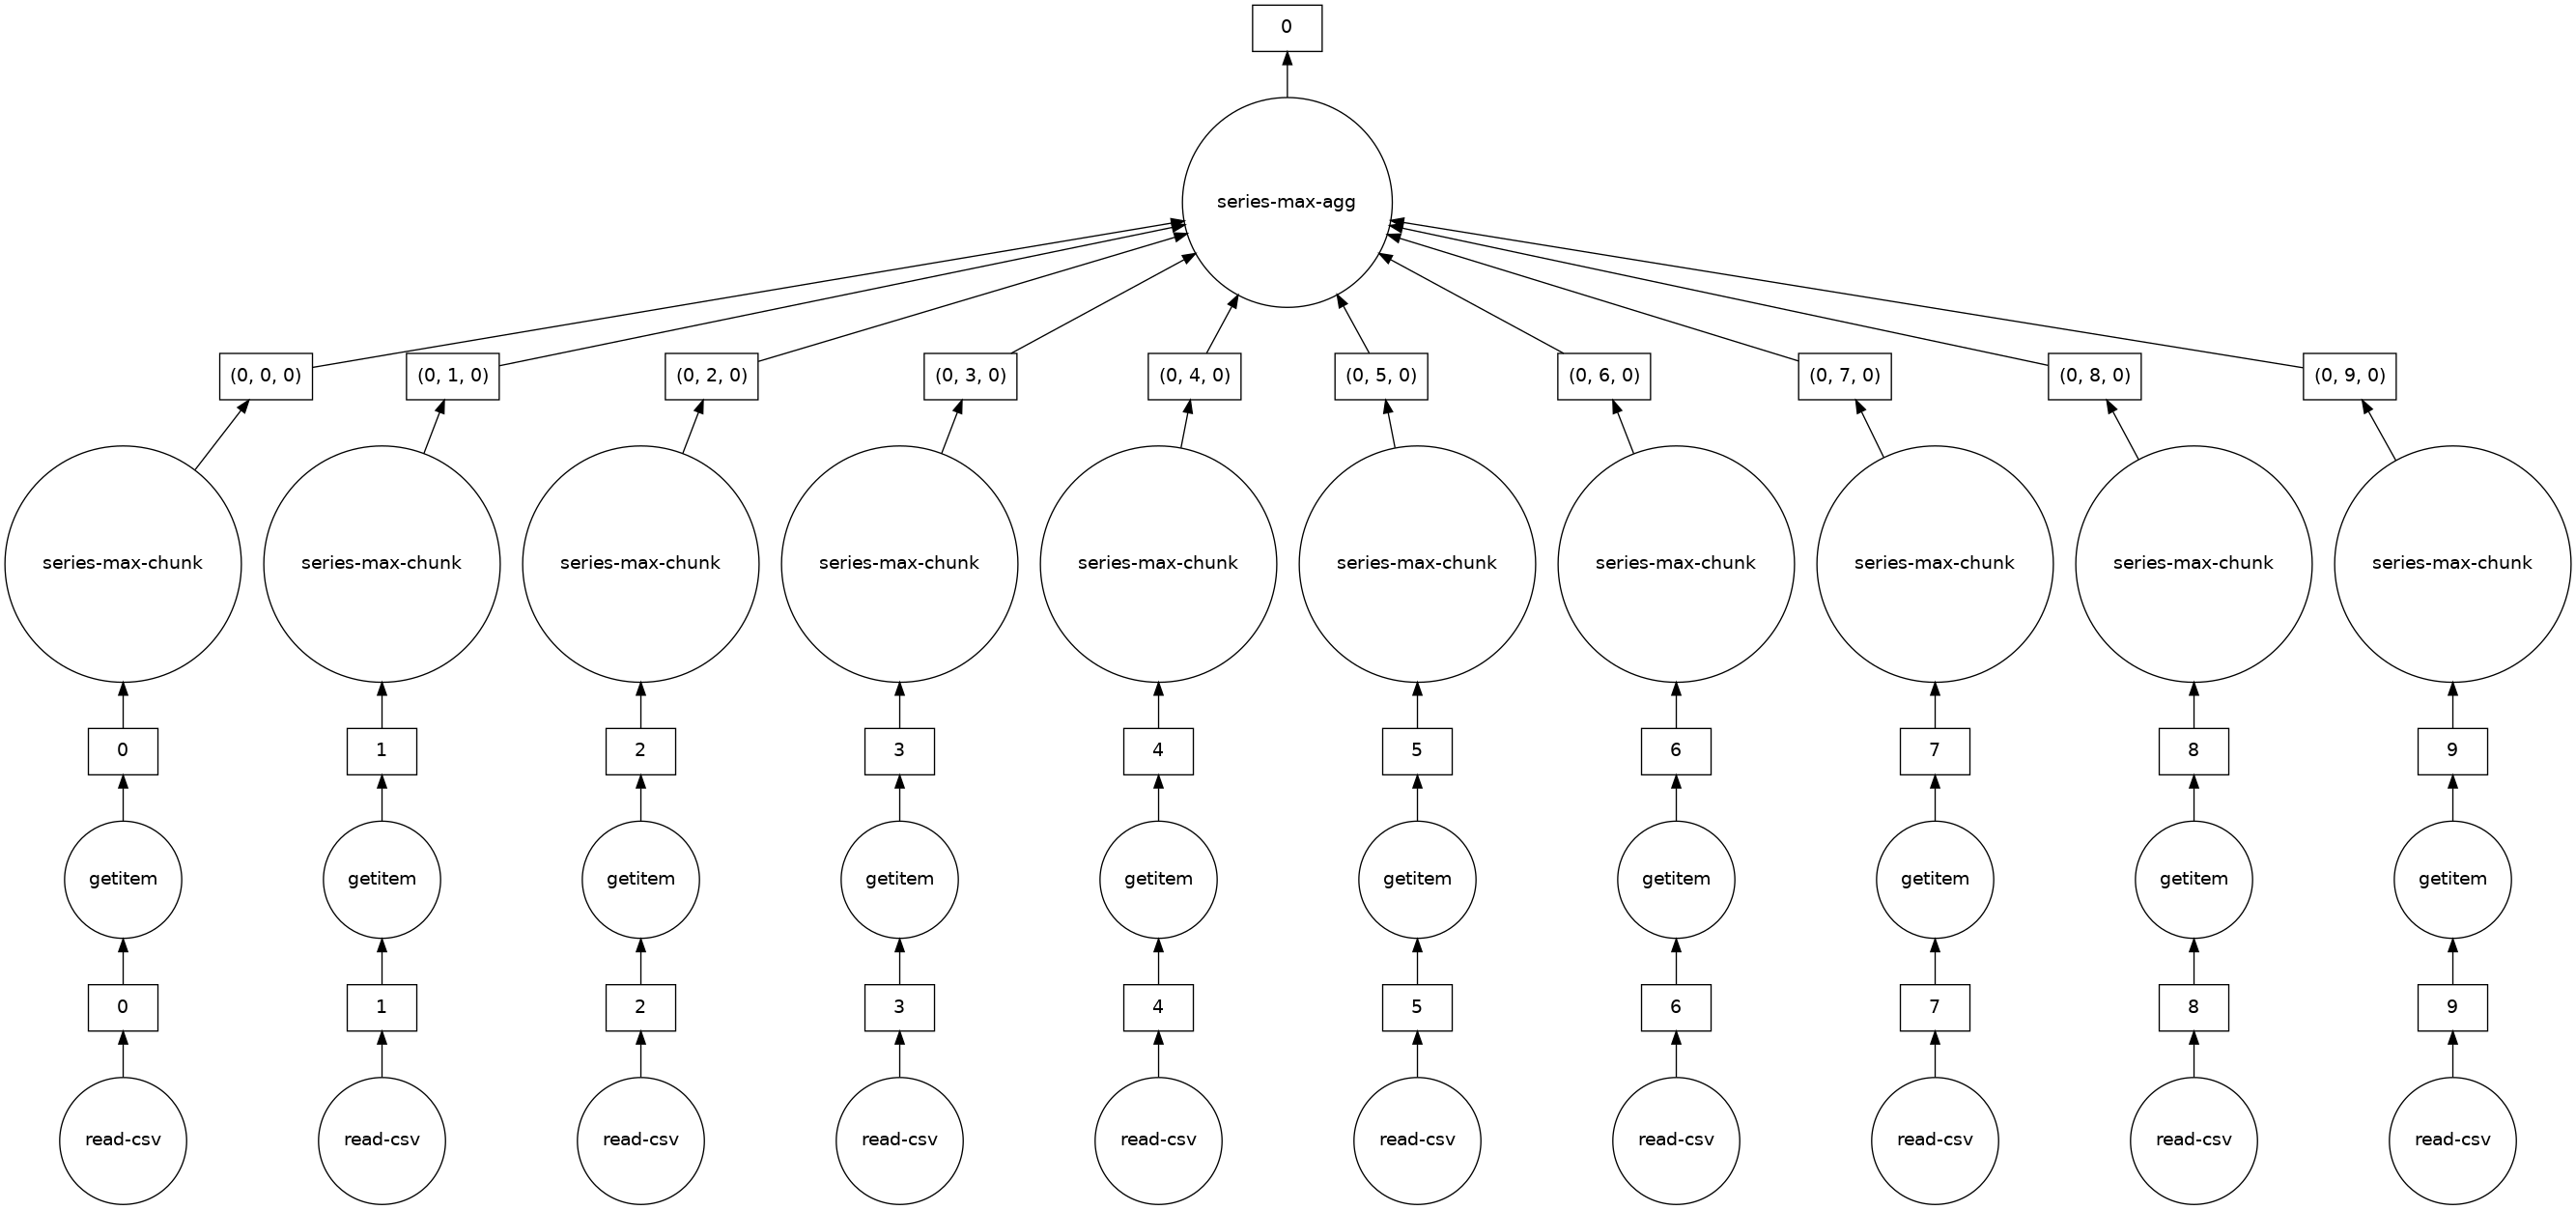

In [15]:
# notice the parallelism
df.DepDelay.max().visualize()

## Exercises

In this section we do a few `dask.dataframe` computations. If you are comfortable with Pandas then these should be familiar. You will have to think about when to call `compute`.

### 1.) How many rows are in our dataset?

If you aren't familiar with pandas, how would you check how many records are in a list of tuples?

In [16]:
# Your code here

In [17]:
len(df)

9990

### 2.) In total, how many non-canceled flights were taken?

With pandas, you would use [boolean indexing](https://pandas.pydata.org/pandas-docs/stable/indexing.html#boolean-indexing).

In [18]:
# Your code here

In [19]:
len(df[~df.Cancelled])

9383

### 3.) In total, how many non-cancelled flights were taken from each airport?

*Hint*: use [`df.groupby`](https://pandas.pydata.org/pandas-docs/stable/groupby.html).

In [20]:
# Your code here

In [21]:
df[~df.Cancelled].groupby('Origin').Origin.count().compute()

Origin
EWR    4132
JFK    1085
LGA    4166
Name: Origin, dtype: int64

### 4.) What was the average departure delay from each airport?

Note, this is the same computation you did in the previous notebook (is this approach faster or slower?)

In [22]:
# Your code here

In [23]:
df.groupby("Origin").DepDelay.mean().compute()

Origin
EWR    12.500968
JFK    17.053456
LGA    10.169227
Name: DepDelay, dtype: float64

### 5.) What day of the week has the worst average departure delay?

In [24]:
# Your code here

In [25]:
df.groupby("DayOfWeek").DepDelay.mean().compute()

DayOfWeek
1    10.677698
2     8.633310
3    14.208160
4    14.187853
5    15.209929
6     9.540307
7    10.609375
Name: DepDelay, dtype: float64

### 6.) What holiday has the worst average departure delay?

*Hint*: use [`df.merge`](https://pandas.pydata.org/pandas-docs/stable/user_guide/merging.html) to bring holiday information.

*Note*: If you have prepared the dataset with `--small` argument or set the `DASK_TUTORIAL_SMALL` environment variable to `True`, you might see only a couple of holidays. This is because the small dataset contains a limited number of rows.

In [26]:
# Your code here

In [27]:
df.merge(holidays, on=["Date"], how="left").groupby("holiday").DepDelay.mean().compute()

holiday
Martin Luther King Jr. Day    12.198718
New Year's Day                11.993151
New Year's Day (Observed)     13.714286
Name: DepDelay, dtype: float64

## Sharing Intermediate Results

When computing all of the above, we sometimes did the same operation more than once. For most operations, `dask.dataframe` hashes the arguments, allowing duplicate computations to be shared, and only computed once.

For example, lets compute the mean and standard deviation for departure delay of all non-canceled flights. Since dask operations are lazy, those values aren't the final results yet. They're just the recipe required to get the result.

If we compute them with two calls to compute, there is no sharing of intermediate computations.

In [28]:
non_cancelled = df[~df.Cancelled]
mean_delay = non_cancelled.DepDelay.mean()
std_delay = non_cancelled.DepDelay.std()

In [29]:
%%time

mean_delay_res = mean_delay.compute()
std_delay_res = std_delay.compute()

CPU times: user 80.4 ms, sys: 15.4 ms, total: 95.7 ms
Wall time: 316 ms


But let's try by passing both to a single `compute` call.

In [30]:
%%time

mean_delay_res, std_delay_res = dask.compute(mean_delay, std_delay)

CPU times: user 75.1 ms, sys: 457 µs, total: 75.5 ms
Wall time: 207 ms


Using `dask.compute` takes roughly 1/2 the time. This is because the task graphs for both results are merged when calling `dask.compute`, allowing shared operations to only be done once instead of twice. In particular, using `dask.compute` only does the following once:

- the calls to `read_csv`
- the filter (`df[~df.Cancelled]`)
- some of the necessary reductions (`sum`, `count`)

To see what the merged task graphs between multiple results look like (and what's shared), you can use the `dask.visualize` function (we might want to use `filename='graph.pdf'` to save the graph to disk so that we can zoom in more easily):

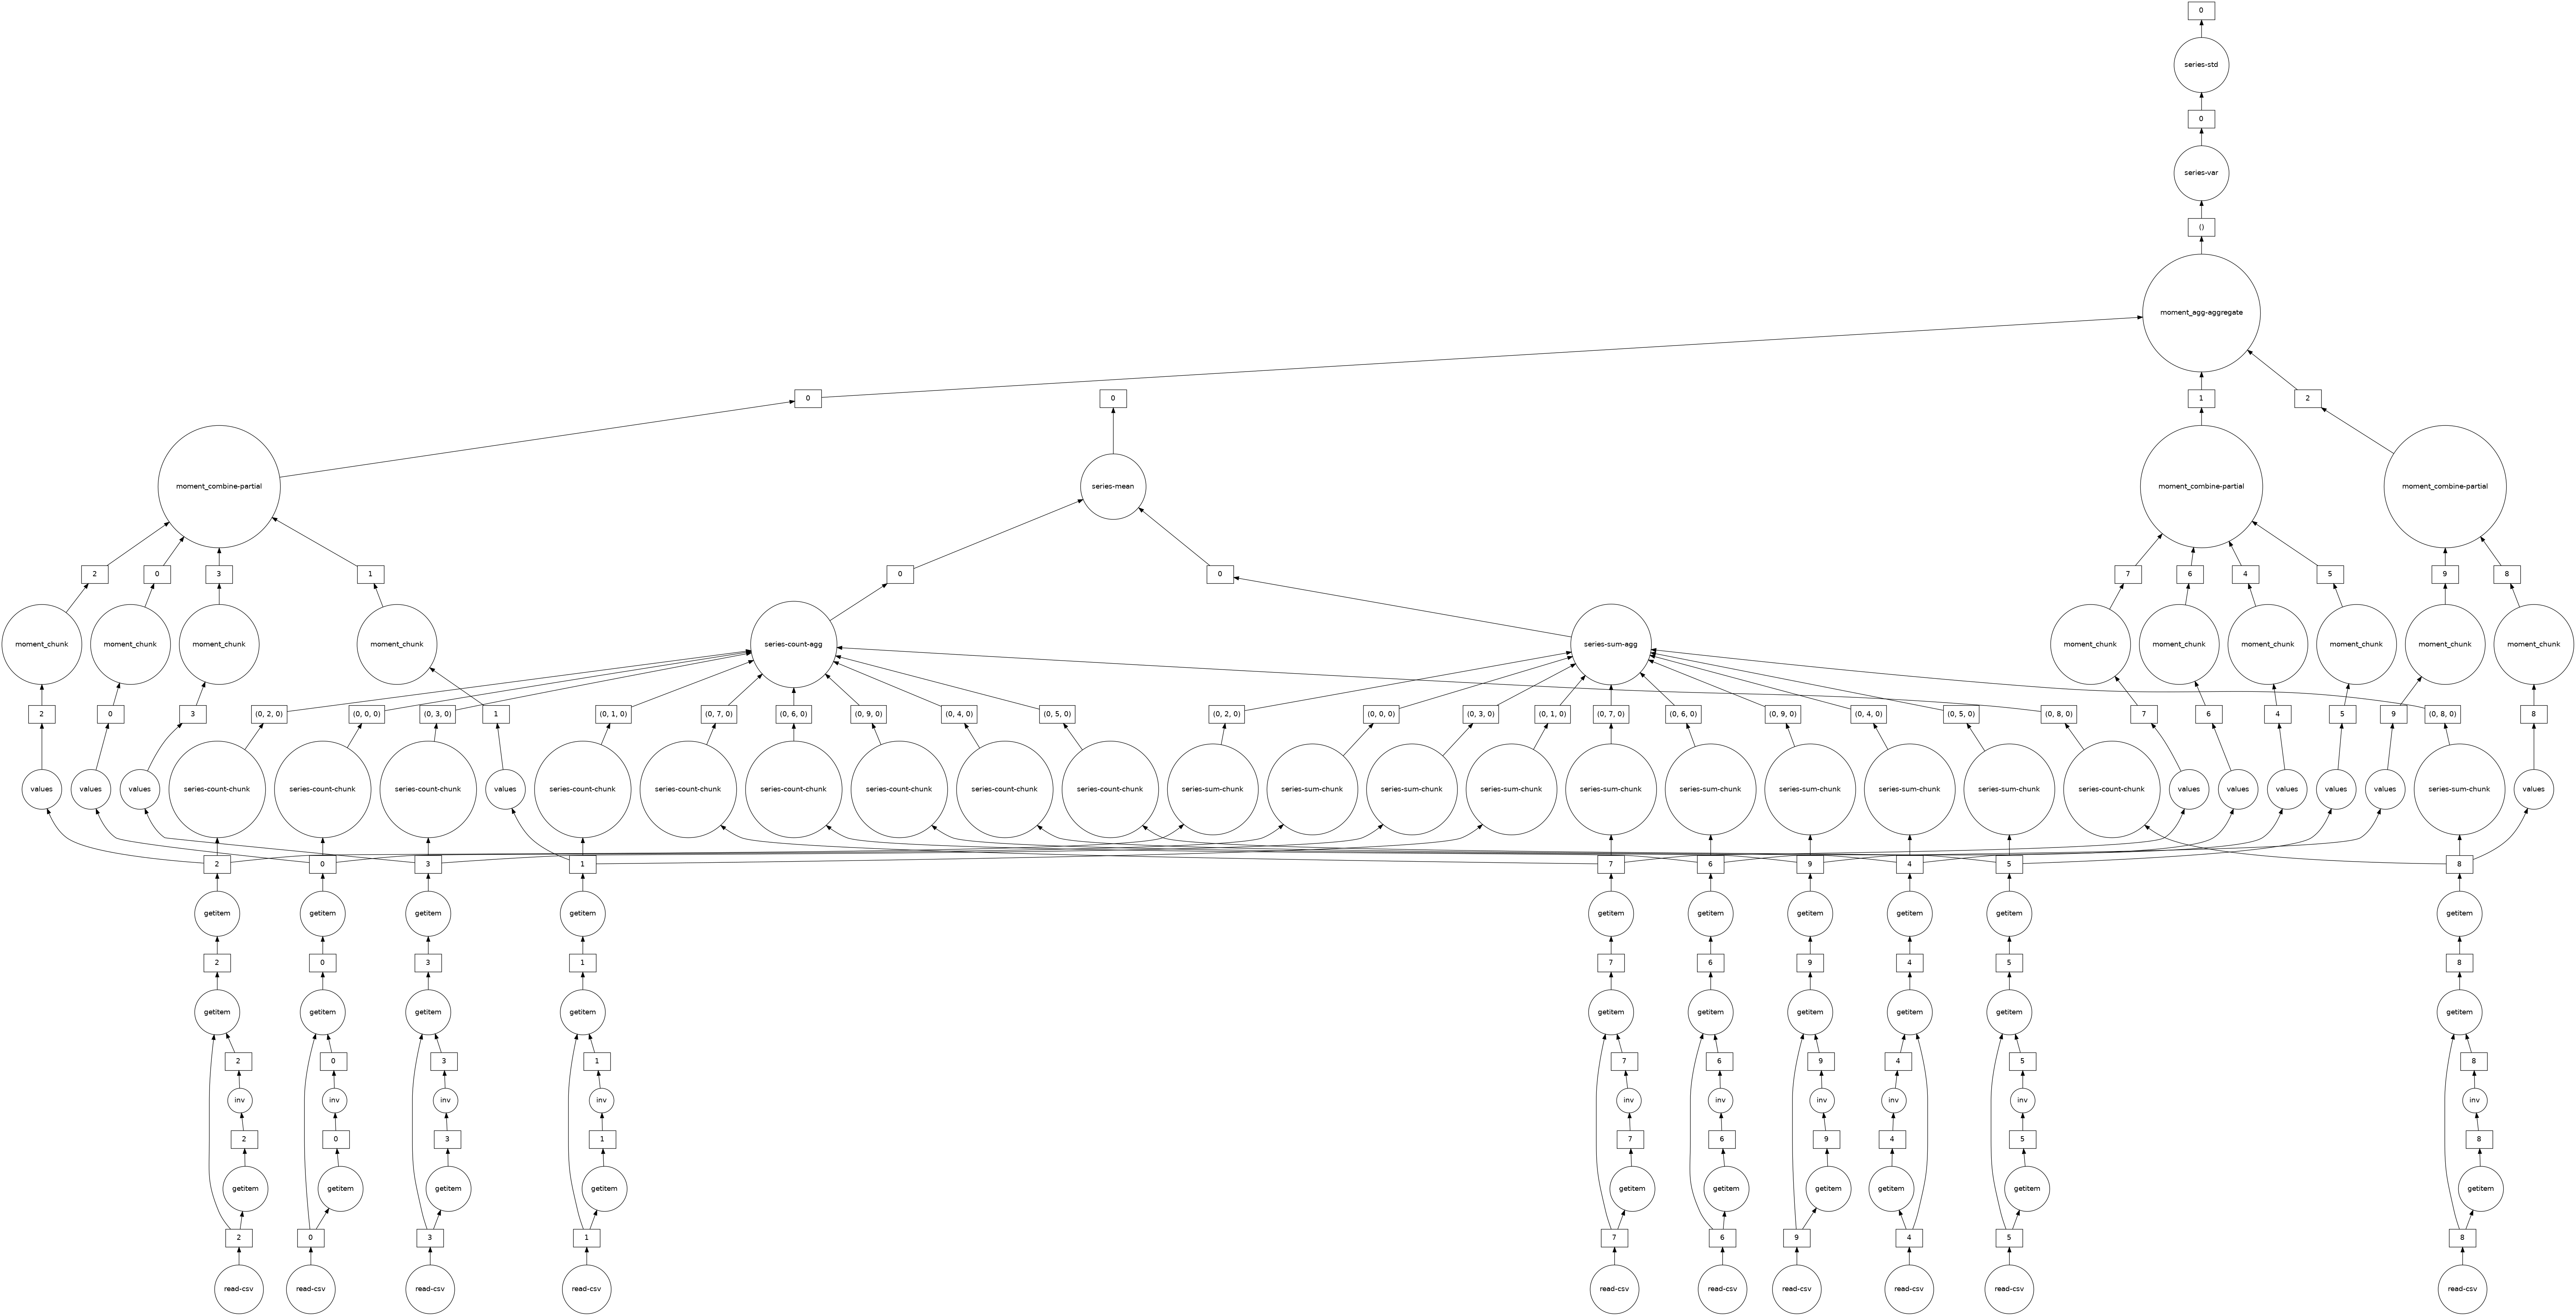

In [31]:
dask.visualize(mean_delay, std_delay)

## How does this compare to Pandas?

Pandas is more mature and fully featured than `dask.dataframe`.  If your data fits in memory then you should use Pandas.  The `dask.dataframe` module gives you a limited `pandas` experience when you operate on datasets that don't fit comfortably in memory.

During this tutorial we provide a small dataset consisting of a few CSV files.  This dataset is 45MB on disk that expands to about 400MB in memory. This dataset is small enough that you would normally use Pandas.

We've chosen this size so that exercises finish quickly.  Dask.dataframe only really becomes meaningful for problems significantly larger than this, when Pandas breaks with the dreaded 

    MemoryError:  ...
    
Furthermore, the distributed scheduler allows the same dataframe expressions to be executed across a cluster. To enable massive "big data" processing, one could execute data ingestion functions such as `read_csv`, where the data is held on storage accessible to every worker node (e.g., amazon's S3), and because most operations begin by selecting only some columns, transforming and filtering the data, only relatively small amounts of data need to be communicated between the machines.

Dask.dataframe operations use `pandas` operations internally.  Generally they run at about the same speed except in the following two cases:

1.  Dask introduces a bit of overhead, around 1ms per task.  This is usually negligible.
2.  When Pandas releases the GIL `dask.dataframe` can call several pandas operations in parallel within a process, increasing speed somewhat proportional to the number of cores. For operations which don't release the GIL, multiple processes would be needed to get the same speedup.

## Dask DataFrame Data Model

For the most part, a Dask DataFrame feels like a pandas DataFrame.
So far, the biggest difference we've seen is that Dask operations are lazy; they build up a task graph instead of executing immediately (more details coming in [Schedulers](05_distributed.ipynb)).
This lets Dask do operations in parallel and out of core.

In [Dask Arrays](03_array.ipynb), we saw that a `dask.array` was composed of many NumPy arrays, chunked along one or more dimensions.
It's similar for `dask.dataframe`: a Dask DataFrame is composed of many pandas DataFrames. For `dask.dataframe` the chunking happens only along the index.

<img src="http://dask.pydata.org/en/latest/_images/dask-dataframe.svg" width="30%">

We call each chunk a *partition*, and the upper / lower bounds are *divisions*.
Dask *can* store information about the divisions. For now, partitions come up when you write custom functions to apply to Dask DataFrames

## Converting `CRSDepTime` to a timestamp

This dataset stores timestamps as `HHMM`, which are read in as integers in `read_csv`:

In [32]:
crs_dep_time = df.CRSDepTime.head(10)
crs_dep_time

0    1540
1    1540
2    1540
3    1540
4    1540
5    1540
6    1540
7    1540
8    1540
9    1540
Name: CRSDepTime, dtype: int64

To convert these to timestamps of scheduled departure time, we need to convert these integers into `pd.Timedelta` objects, and then combine them with the `Date` column.

In pandas we'd do this using the `pd.to_timedelta` function, and a bit of arithmetic:

In [33]:
import pandas as pd

# Get the first 10 dates to complement our `crs_dep_time`
date = df.Date.head(10)

# Get hours as an integer, convert to a timedelta
hours = crs_dep_time // 100
hours_timedelta = pd.to_timedelta(hours, unit='h')

# Get minutes as an integer, convert to a timedelta
minutes = crs_dep_time % 100
minutes_timedelta = pd.to_timedelta(minutes, unit='m')

# Apply the timedeltas to offset the dates by the departure time
departure_timestamp = date + hours_timedelta + minutes_timedelta
departure_timestamp

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
5   1990-01-06 15:40:00
6   1990-01-07 15:40:00
7   1990-01-08 15:40:00
8   1990-01-09 15:40:00
9   1990-01-10 15:40:00
dtype: datetime64[ns]

### Custom code and Dask Dataframe

We could swap out `pd.to_timedelta` for `dd.to_timedelta` and do the same operations on the entire dask DataFrame. But let's say that Dask hadn't implemented a `dd.to_timedelta` that works on Dask DataFrames. What would you do then?

`dask.dataframe` provides a few methods to make applying custom functions to Dask DataFrames easier:

- [`map_partitions`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_partitions)
- [`map_overlap`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.map_overlap)
- [`reduction`](http://dask.pydata.org/en/latest/dataframe-api.html#dask.dataframe.DataFrame.reduction)

Here we'll just be discussing `map_partitions`, which we can use to implement `to_timedelta` on our own:

In [34]:
# Look at the docs for `map_partitions`

help(df.CRSDepTime.map_partitions)

Help on method map_partitions in module dask.dataframe.core:

map_partitions(func, *args, **kwargs) method of dask.dataframe.core.Series instance
    Apply Python function on each DataFrame partition.
    
    Note that the index and divisions are assumed to remain unchanged.
    
    Parameters
    ----------
    func : function
        Function applied to each partition.
    args, kwargs :
        Arguments and keywords to pass to the function. The partition will
        be the first argument, and these will be passed *after*. Arguments
        and keywords may contain ``Scalar``, ``Delayed``, ``partition_info``
        or regular python objects. DataFrame-like args (both dask and
        pandas) will be repartitioned to align (if necessary) before
        applying the function.
    meta : pd.DataFrame, pd.Series, dict, iterable, tuple, optional
        An empty ``pd.DataFrame`` or ``pd.Series`` that matches the dtypes
        and column names of the output. This metadata is necessar

The basic idea is to apply a function that operates on a DataFrame to each partition.
In this case, we'll apply `pd.to_timedelta`.

In [35]:
hours = df.CRSDepTime // 100
# hours_timedelta = pd.to_timedelta(hours, unit='h')
hours_timedelta = hours.map_partitions(pd.to_timedelta, unit='h')

minutes = df.CRSDepTime % 100
# minutes_timedelta = pd.to_timedelta(minutes, unit='m')
minutes_timedelta = minutes.map_partitions(pd.to_timedelta, unit='m')

departure_timestamp = df.Date + hours_timedelta + minutes_timedelta

In [36]:
departure_timestamp

Dask Series Structure:
npartitions=10
    datetime64[ns]
               ...
         ...      
               ...
               ...
dtype: datetime64[ns]
Dask Name: add, 90 tasks

In [37]:
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

### Exercise: Rewrite above to use a single call to `map_partitions`

This will be slightly more efficient than two separate calls, as it reduces the number of tasks in the graph.

In [38]:
def compute_departure_timestamp(df):
    pass  # TODO: implement this

In [39]:
departure_timestamp = df.map_partitions(compute_departure_timestamp)

departure_timestamp.head()

/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
distributed.w

AttributeError: 'NoneType' object has no attribute 'head'

In [40]:
def compute_departure_timestamp(df):
    hours = df.CRSDepTime // 100
    hours_timedelta = pd.to_timedelta(hours, unit='h')

    minutes = df.CRSDepTime % 100
    minutes_timedelta = pd.to_timedelta(minutes, unit='m')

    return df.Date + hours_timedelta + minutes_timedelta

departure_timestamp = df.map_partitions(compute_departure_timestamp)
departure_timestamp.head()

0   1990-01-01 15:40:00
1   1990-01-02 15:40:00
2   1990-01-03 15:40:00
3   1990-01-04 15:40:00
4   1990-01-05 15:40:00
dtype: datetime64[ns]

## Limitations

### What doesn't work?

Dask.dataframe only covers a small but well-used portion of the Pandas API.
This limitation is for two reasons:

1.  The Pandas API is *huge*
2.  Some operations are genuinely hard to do in parallel (e.g. sort)

Additionally, some important operations like ``set_index`` work, but are slower
than in Pandas because they include substantial shuffling of data, and may write out to disk.

## Learn More


* [DataFrame documentation](https://docs.dask.org/en/latest/dataframe.html)
* [DataFrame screencast](https://youtu.be/AT2XtFehFSQ)
* [DataFrame API](https://docs.dask.org/en/latest/dataframe-api.html)
* [DataFrame examples](https://examples.dask.org/dataframe.html)
* [Pandas documentation](https://pandas.pydata.org/pandas-docs/stable/)

In [41]:
client.shutdown()

/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/share/miniconda3/envs/dask-tutorial/lib/python3.8/site-packages/dask/dataframe/backends.py:187: FutureWarning: pandas.UInt64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  _numeric_index_types = (pd.Int64Index, pd.Float64Index, pd.UInt64Index)
/usr/share/mi